# Spiking data and population burst events 


In [18]:
%matplotlib inline

## Read spike data 

### Spike data was stored in a MATLAB data structure and here we need to retrieve it. It contains information on spike timing, spatial tuning, stability, animal velocity at spike time, etc

### Cluster Quality (L-ratios)

In [2]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import random
import h5py
import mplcursors
from learned_tuning.Bayesian_decoder import Bayesian_decoder
from learned_tuning.learned_tuning import calculate_learned_tuning, calculate_place_field_fidelity_of_learned_tuning

data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'

# Load .mat file
filename = 'Achilles_10252013.clusterQuality.mat'
file_path = os.path.join(data_dir, filename)


mat_file = scipy.io.loadmat(file_path)

# Access data structure

num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

L_ratios = list()
for shank in range(num_shanks):    
    curr_shank_L_ratios = dict()
    curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
    curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
    
    L_ratios.append(curr_shank_L_ratios)

#####  Plot the L-ratios for the example shank

3.415756102675768e-07 0.00022119372263319223 0.013073590387247244


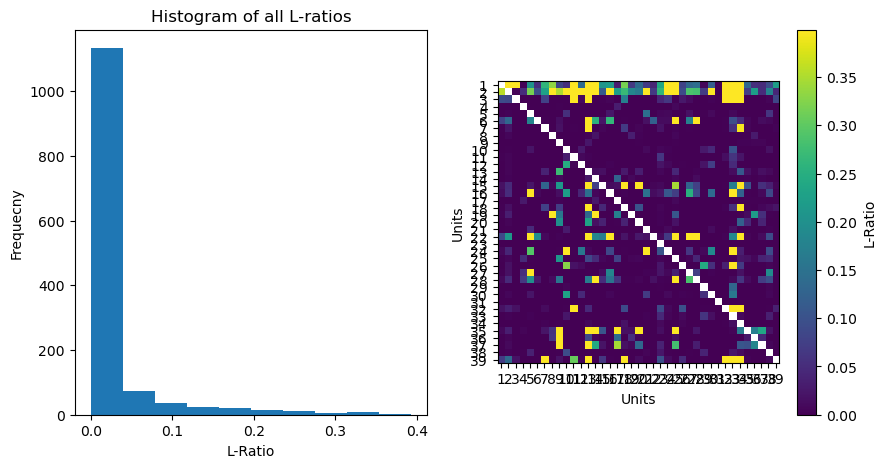

In [3]:
L_ratios_example_shank = L_ratios[4]["L_ratios"]

num_units, num_units = L_ratios_example_shank.shape

# Flatten the array to create a 1D array of all values
all_L_ratios = L_ratios_example_shank.flatten()

# Calculate the 5th and 95th percentiles. 
vmin, vmax = np.nanpercentile(all_L_ratios, [5, 95])

p25, median, p75 = np.nanpercentile(all_L_ratios, [25, 50, 75])

print(p25, median, p75)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))


# Plot a histogram of all L-Ratios
all_L_ratios_filtered = all_L_ratios[(all_L_ratios >= vmin) & (all_L_ratios <= vmax)]

ax1.hist(all_L_ratios_filtered)
ax1.set_title('Histogram of all L-ratios')
ax1.set_xlabel('L-Ratio')
ax1.set_ylabel('Frequecny')


# Display the L-Ratios as an image using imshow()


img = ax2.imshow(L_ratios_example_shank, vmin = vmin, vmax = vmax) # limit the range in color code to 5 and 95 percentiles
cb = fig.colorbar(img, ax = ax2, label = 'L-Ratio')

ax2.set_xticks(range(num_units))
ax2.set_yticks(range(num_units))

ax2.set_xticklabels([str(i+1) for i in range(num_units)])
ax2.set_yticklabels([str(i+1) for i in range(num_units)])


ax2.set_xlabel('Units')
ax2.set_ylabel('Units')


plt.show()

##### Calculate how many pairs satisfy the criterion L-Ratio < 1e-3 

In [4]:
L_ratio_thresh = 1e-3
small_L_ratio_percentage = all_L_ratios[all_L_ratios <= L_ratio_thresh].size/all_L_ratios.size
print(small_L_ratio_percentage*100)

55.818540433925044


### Place Fields

148 95


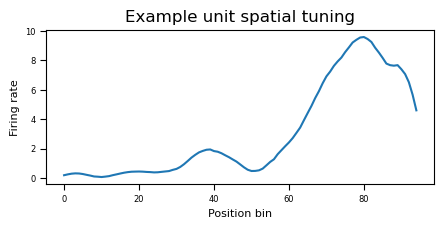

position bin with the peak firing rate is 81


In [5]:
data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'

# Load .mat file
filename = 'Achilles_10252013.spikes_for_python.mat'
file_path = os.path.join(data_dir, filename)

mat_file = scipy.io.loadmat(file_path)
spikes_pyr = mat_file["spikes_pyr"]


#### Extracting all place fields from the imported .mat file
spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]

num_units    = spatial_tuning_smoothed[0].shape[0]
num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

print(num_units, num_pos_bins)

spikes = []; # spike data and place field info of each unit

# attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
running_directions = {'LR', 'RL', 'uni'}
other_attributes   = {'spike_times', 'shank_id','cluster_id'}

for unit in range(num_units):
    
    # Create dictionaries for each unit and store the matrices
    
    unit_spikes = dict()
    
    unit_spikes['place_fields']  = {}
    unit_spikes['peak_pos_bins'] = {}
    for direction in running_directions:
        unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[0][unit][direction][0][0].reshape(num_pos_bins) 
        unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]

    unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
    unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]
    unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]
        
    spikes.append(unit_spikes) 
    
# pltttong the place field corresponding to a running direction for an example unit
example_unit = 5

fig, ax = plt.subplots(figsize=(5, 2), dpi=100)

ax.plot(spikes[example_unit]['place_fields']['uni'])

ax.tick_params(axis='both', which='major', length=4, labelsize= 6) 
ax.set_xlabel("Position bin", fontsize=8)
ax.set_ylabel("Firing rate", fontsize=8)
plt.title("Example unit spatial tuning")

# Set up the cursor to display values on click
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(
    f'x={sel.target[0]:.2f}, y={sel.target[1]:.2f}'))

plt.show()

print(f"position bin with the peak firing rate is {spikes[example_unit]['peak_pos_bins']['uni']}")


In [6]:
data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'

# Load .mat file
filename = 'Achilles_10252013.fileInfo_for_python.mat'
file_path = os.path.join(data_dir, filename)

mat_file = scipy.io.loadmat(file_path)
session_info = mat_file["fileInfo"]

epochs = session_info["behavior"][0][0][0][0]["time"]
print(epochs)

[[    0.     18079.5   ]
 [18079.5    20147.    ]
 [20147.     34861.1032]]


#### Plot place fields sorted based on the peak firing rate locations 


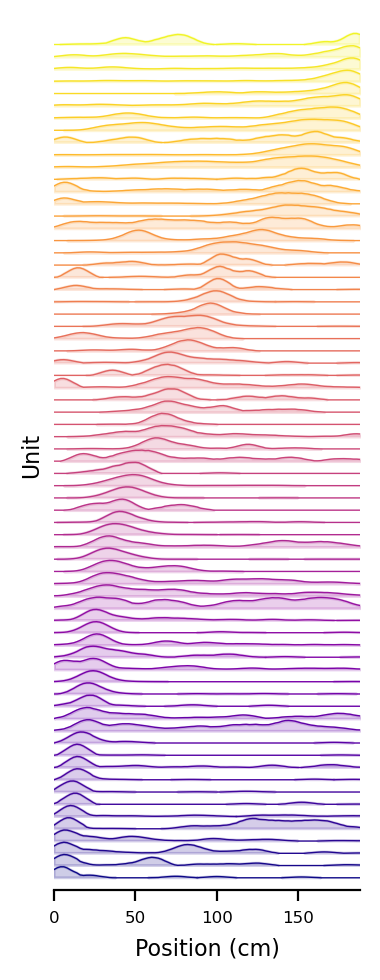

In [7]:
# place fields in RL running direction

place_fields_RL = []
peak_pos_bins_RL = []
for unit in range(num_units):
    place_fields_RL.append(spikes[unit]['place_fields']['RL'])    
    peak_pos_bins_RL.append(spikes[unit]['peak_pos_bins']['RL'])
    
place_fields_RL = np.array(place_fields_RL)
peak_pos_bins_RL = np.array(peak_pos_bins_RL)

peak_place_field_sorting_indices = np.argsort(peak_pos_bins_RL)


# Create an array of original row indices
original_row_indices = np.arange(num_units)


place_fields_sorted = place_fields_RL[peak_place_field_sorting_indices]
original_row_indices_sorted = original_row_indices[peak_place_field_sorting_indices]


# Find the maximum value in each row of the matrix
max_vals = np.amax(place_fields_sorted, axis=1)

# Create a boolean mask for rows with a maximum value >= 1
mask = max_vals >= 1

# Select the rows that you want to plot
selected_rows = place_fields_sorted[mask]
selected_row_indices = original_row_indices_sorted[mask]

# Normalize each curve to a maximum of 1
selected_rows = selected_rows / np.amax(selected_rows, axis=1, keepdims=True) * 0.9

# Define the x-axis values (e.g. position bins)
x = np.arange(num_pos_bins)

# Create the plot
fig, ax = plt.subplots(figsize=(2, 5), dpi=200)

# Set the colormap to "viridis"
cmap = plt.get_cmap("plasma")

# Loop over each selected row of the matrix and plot a filled curve
for i in range(selected_rows.shape[0]):
    y = selected_rows[i]  # Select the i-th row of the matrix
    ax.fill_between(x, y + i, i, where=y > 0, interpolate=True, alpha=0.2, color=cmap(i/selected_rows.shape[0]))
    ax.plot(x, y + i, color=cmap(i/selected_rows.shape[0]), alpha=1, linewidth=0.5)

# Set the y-axis limits and labels
ax.set_ylim(-1, selected_rows.shape[0] + 1)
ax.set_yticks(np.arange(selected_rows.shape[0]))
ax.set_yticklabels(np.arange(selected_rows.shape[0]) + 1)

# Set the x-axis limits and labels
ax.set_xlim(x[0], x[-1])
ax.set_xlabel("Position (cm)", fontsize=8)
ax.set_ylabel("Unit", fontsize=8)
ax.set_yticks([]) # set y-axis ticks to an empty list
ax.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks


# Set x-axis tick labels in intervals of 10 and multiply by 2
new_ticks = [int(bin)*2 for bin in range(num_pos_bins)[::25]]
ax.set_xticks(range(num_pos_bins)[::25])
ax.set_xticklabels(new_ticks)

# Remove the box
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add white space
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
fig.tight_layout()

# Show the plot
plt.show()

# fig.savefig("myplot.pdf", format="pdf")

### Population burst events (PBEs)

In [8]:
data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
filename = 'Achilles_10252013.PBEInfo_replayScores.mat'

file_path = os.path.join(data_dir, filename)
f = h5py.File(file_path, "r")

PBEInfo = f['PBEInfo_replayScores']

print(list(PBEInfo.keys()))

['MUAWave', 'SWA', 'begPosition', 'brainState', 'coveredLen', 'duration', 'emg', 'endPosition', 'endT', 'epoch', 'fr_1msbin', 'fr_20msbin', 'jumpDist', 'linearPos', 'n', 'nFiringUnits', 'nTimeBins', 'onlyLineElements', 'peakMUA', 'peakRippleA', 'peakT', 'postMat_nonNorm', 'posteriorProbMat', 'radonIntegral', 'replayOrderScore', 'replayOrderScore_prctile', 'rippleWave', 'rt_ds', 'rt_pf', 'rt_ts', 'rt_ui', 'sessionName', 'startT', 'thetaRatio', 'velocity', 'vmaxsign', 'wc_ds', 'wc_pf', 'wc_ts', 'wc_ui', 'weightedCorr']


#### Store the population burst events in a new variable 


In [9]:
# Define a list of PBE dictionaries
PBEs = []

# Define the number of PBEs and matrix types
num_PBEs = PBEInfo["fr_1msbin"].shape[0]

attributes = list(PBEInfo.keys())

# Loop over the PBEs and create a dictionary for each one
for pbe in range(num_PBEs):   
    # Create a dictionary for the PBE and store the matrices
    PBE_dict = {}
    for attr in attributes:
        ref = PBEInfo[attr][pbe][0]
        obj = f[ref] 
        PBE_dict[attr] = np.array(obj) 

    PBEs.append(PBE_dict)

#### Let's see if we can do decode position during the PBEs using the Bayesian decoding algorithm and place fields

Text(0.5, 1.0, 'posterior_Matlab')

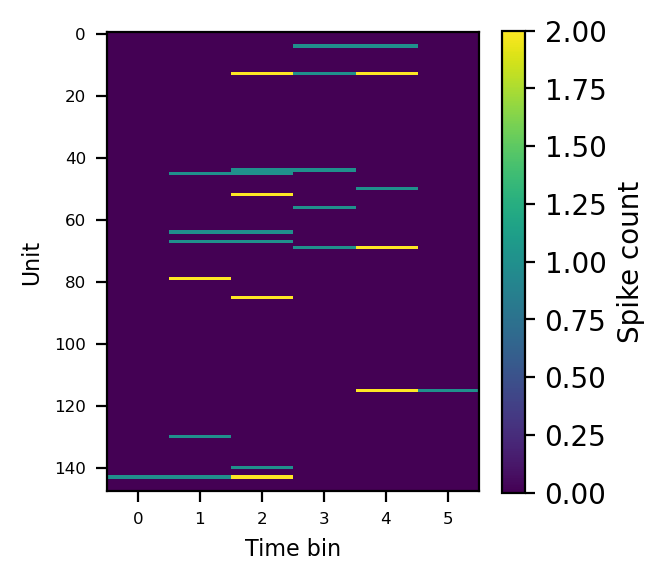

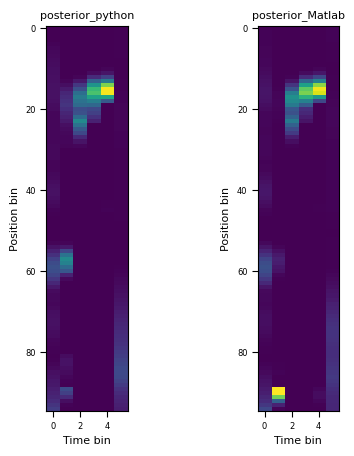

In [10]:
def normalize_columns(matrix):
    """
    Takes a matrix as input and returns a new matrix where each column sums up to one (a probability distribution)
    """
    # calculate the sum of each column
    col_sum = np.sum(matrix, axis=0)
    
    # divide each element in a column by its sum
    normalized_matrix = matrix / col_sum[np.newaxis, :]
    
    return normalized_matrix


# spike count per 20 ms time bin for an example event
# example_unit = int(input("Enter the example unit: "))
example_unit = 5

PBE_each_bin_spike_counts = PBEs[example_unit]["fr_20msbin"].transpose()

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

img = ax.imshow(PBE_each_bin_spike_counts, aspect = 0.05)

ax.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks
ax.set_xlabel("Time bin", fontsize=8)
ax.set_ylabel("Unit", fontsize=8)
cb = fig.colorbar(img, ax = ax, label = 'Spike count')


# Let's perfrom Bayesian decoding on the example PBE
# Decode the position given the place fields in each direction and then marginalize 

# place fields in LR running direction
place_fields_LR = []
for unit in range(num_units):
    place_fields_LR.append(spikes[unit]['place_fields']['LR'])    
place_fields_LR = np.array(place_fields_LR)

place_fields_LR[place_fields_LR == 0] = 1e-4


# place fields in RL running direction
place_fields_RL = []
for unit in range(num_units):
    place_fields_RL.append(spikes[unit]['place_fields']['RL'])
place_fields_RL = np.array(place_fields_RL)

place_fields_RL[place_fields_RL == 0] = 1e-4


time_bin_duration = 0.02; # in seconds
num_position_bins = place_fields_LR.shape[1] 
num_time_bins = PBE_each_bin_spike_counts.shape[1]


posterior_LR = Bayesian_decoder(PBE_each_bin_spike_counts, place_fields_LR, time_bin_duration) # RL direction
posterior_RL = Bayesian_decoder(PBE_each_bin_spike_counts, place_fields_RL, time_bin_duration) # LR direction

posterior = posterior_LR + posterior_RL
posterior_normalized = normalize_columns(posterior)


# Eliminate the posteriors calculated in time bins with no firing
posterior_normalized[:, np.sum(PBE_each_bin_spike_counts, axis = 0) == 0] = 0;



# Let's compare the posteriors with the ones calculated in matlab
posterior_calculated_matlab = PBEs[example_unit]["posteriorProbMat"]
posterior_calculated_matlab = np.transpose(posterior_calculated_matlab)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 5), dpi = 100)

img = ax1.imshow(posterior_normalized, vmin = 0, vmax = 0.23, aspect = 0.3) 

ax1.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks
ax1.set_xlabel("Time bin", fontsize=8)
ax1.set_ylabel("Position bin", fontsize=8)
ax1.set_title("posterior_python", fontsize=8)
# cb = fig.colorbar(img, ax = ax1, label = 'Posterior probability')


img = ax2.imshow(posterior_calculated_matlab, vmin = 0, vmax = 0.23, aspect = 0.3)

ax2.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks
ax2.set_xlabel("Time bin", fontsize=8)
ax2.set_ylabel("Position bin", fontsize=8)
ax2.set_title("posterior_Matlab", fontsize=8)
# cb = fig.colorbar(img, ax = ax2, label = 'Posterior probability')


### Learned tunings

In [11]:
# Subselect PBEs for calculation of learned tunings
# Maze Epoch

num_PBEs = len(PBEs)
PBEs_peak_time = np.zeros((num_PBEs, 1))

for pbe in range(num_PBEs):
    PBEs_peak_time[pbe] = PBEs[pbe]["peakT"]

# PRE epoch 
select_IDX = np.where((PBEs_peak_time >= epochs[0,1]-1800) & (PBEs_peak_time <= epochs[0,1]))[0] # the first hour of POST
PBEs_PRE = np.take(PBEs, select_IDX)

# MAZE epoch
select_IDX = np.where((PBEs_peak_time >= epochs[1,0]) & (PBEs_peak_time <= epochs[1,1]))[0] # the first hour of POST
PBEs_MAZE = np.take(PBEs, select_IDX)

# POST epoch
select_IDX = np.where((PBEs_peak_time >= epochs[2,0]) & (PBEs_peak_time <= epochs[2,0]+1800))[0] # the first hour of POST
PBEs_POST = np.take(PBEs, select_IDX)


time_bin_duration=0.02
learned_tunings = calculate_learned_tuning(PBEs_MAZE, spikes, L_ratios, time_bin_duration)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # we have division by zeros somewhere in the code that we need to fix, but for now we suppress it because it's not causing an issue ...


# To check if the Python code works well, we compare the learned tunings with the one calcualted using MATLAB

data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'

# Load .mat file
filename = 'Achilles_10252013.assemblyTunings_allPBEs_Lthresh1e_3.mat'
file_path = os.path.join(data_dir, filename)

mat_file = scipy.io.loadmat(file_path)

epoch = "run"
learned_tunings_post_matlab = mat_file["assemblyTunings"][epoch][0][0][0]["data"][0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), dpi = 100)

normalized_LTs = learned_tunings_post_matlab / np.max(learned_tunings_post_matlab, axis=1, keepdims=True)
ax1.imshow(normalized_LTs[selected_row_indices, :], origin='lower')
ax1.set_title("POST learend tuning MATLAB")

normalized_LTs = learned_tunings / np.max(learned_tunings, axis=1, keepdims=True)
ax2.imshow(normalized_LTs[selected_row_indices, :], origin='lower')
ax2.set_title("POST learend tuning Python")


In [78]:
active_units = dict()

active_units["pre"] = mat_file["activeUnits"]["pre"][0][0]
active_units["maze"] = mat_file["activeUnits"]["run"][0][0]
active_units["post"] = mat_file["activeUnits"]["post"][0][0]

active_units_epochs_intersect = np.intersect1d(np.intersect1d(active_units["pre"], active_units["post"]), active_units["maze"])
active_units_epochs_intersect = active_units_epochs_intersect - 1 # to make the indices compatible with the python indexing

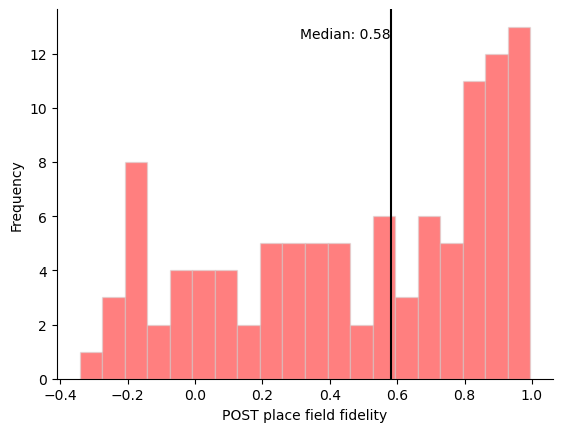

In [79]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # we have division by zeros somewhere in the code that we need to fix, but for now we suppress it because it's not causing an issue ...


# place fields by pooling spikes across both running directions
place_fields_uni = []
for unit in range(num_units):
    place_fields_uni.append(spikes[unit]['place_fields']['uni'])
place_fields_uni = np.array(place_fields_uni)

place_fields_uni[place_fields_uni == 0] = 1e-4

learned_tuning_place_field_pearson_corr, median_LT_PF_pearson_corr, p_value = calculate_place_field_fidelity_of_learned_tuning(learned_tunings[active_units_epochs_intersect, :], place_fields_uni[active_units_epochs_intersect, :], 20)


# plot the distribution of the learned tuning place field pearson correlation
fig, ax = plt.subplots()
n, bins, patches = ax.hist(learned_tuning_place_field_pearson_corr, bins=20, edgecolor='lightgray', alpha=0.5, color='r')

# Calculate and plot nanmedian
nanmedian = np.nanmedian(learned_tuning_place_field_pearson_corr)
ax.axvline(nanmedian, color='black', linestyle='-')
ax.text(nanmedian, n.max(), f'Median: {nanmedian:.2f}', ha='right', va='top')

# Set plot title and labels
ax.set_xlabel('POST place field fidelity')
ax.set_ylabel('Frequency')

# Remove box around figure
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Show the plot
plt.show()



### How many ripples are needed to calculate the learned tunings
The code performs calculations of learned tunings based on different subsets of PBEs to investigate the effect of PBE subset size on the learned tunings' fidelity to corresponding place fields


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # we have division by zeros somewhere in the code that we need to fix, but for now we suppress it because it's not causing an issue ...


num_iterations = 10  # Number of iterations
step_size = 1
maximum_subset_size = 100 #len(PBEs_POST)
random.seed(100)  # Set random seed for reproducibility
time_bin_duration=0.02
num_PF_shuffles = 10000 # number of place field unit ID shuffles to calculate the null distributions

def process_subset(subset_size):
    # print(f"subset_size =  {subset_size}")

    subset_indices = random.sample(range(len(PBEs_POST)), subset_size + 1)  # Randomly sample subset indices
    PBE_subset = [PBEs_POST[i] for i in subset_indices]  # Get the randomized subset of PBEs

    # Execute base process on the PBE subset:
    # caluclate the learned tunings
    learned_tunings = calculate_learned_tuning(PBE_subset, spikes, L_ratios, time_bin_duration)
    
    # calculate PF fidelities of the learned tunings
    learned_tuning_place_field_pearson_corr, median_LT_PF_pearson_corr, _ = calculate_place_field_fidelity_of_learned_tuning(learned_tunings[active_units_epochs_intersect, :], place_fields_uni[active_units_epochs_intersect, :], num_PF_shuffles)

    return subset_size, learned_tuning_place_field_pearson_corr, median_LT_PF_pearson_corr


learned_tunings_PBE_subsets_diff_sizes = {}  # Use dictionary to store results by subset size
median_LT_PF_pearson_corr_diff_sizes = {}

# Creat a  pool of processes
num_processes = 14
pool = multiprocessing.Pool(processes = num_processes)

# Create a list of subset sizes to process in parallel
subset_sizes = list(range(step_size, maximum_subset_size, step_size)) 

for subset_size in subset_sizes:
    learned_tunings_PBE_subsets_diff_sizes[subset_size] = np.full((num_units, num_iterations), np.nan)
    median_LT_PF_pearson_corr_diff_sizes[subset_size] = []


# Loop for each iteration
for i in range(num_iterations):
    print(f"Iteration {i+1}")

    # Use the pool to process the subset sizes in parallel
    results = pool.map(process_subset, subset_sizes)

    # Store results in dictionary by subset size
    for subset_size, learned_tuning_place_field_pearson_corr, median_LT_PF_pearson_corr in results:
        learned_tunings_PBE_subsets_diff_sizes[subset_size][:, i] = learned_tuning_place_field_pearson_corr
        median_LT_PF_pearson_corr_diff_sizes[subset_size].append(median_LT_PF_pearson_corr)


# Storing the results

storage_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python'

filename = 'Achilles_10252013.learned_tunings_vs_ripple_subset_size_POST.npy'
file_path = os.path.join(storage_dir, filename)
np.save(file_path, learned_tunings_PBE_subsets_diff_sizes)


filename = 'Achilles_10252013.learned_tunings_vs_ripple_subset_size_medians_POST.npy'
file_path = os.path.join(storage_dir, filename)
np.save(file_path, median_LT_PF_pearson_corr_diff_sizes)

# loaded_data = np.load(file_path, allow_pickle=True) # use this to read the files


In [138]:
# In case, we want to upload previously saved results

# filename = 'Achilles_10252013.learned_tunings_vs_ripple_subset_size_PRE.npy'
# file_path = os.path.join(storage_dir, filename)

# loaded_data = np.load(file_path, allow_pickle=True) # use this to read the files



# if we want to limit the results to active_units_epochs_intersect. Now we don't need to worry about this because we updated the cell above

# subset_sizes = list(range(step_size, maximum_subset_size, step_size)) 

# learned_tunings_PBE_subsets_diff_sizes = {}  # Use dictionary to store results by subset size
# median_LT_PF_corr = {}


# for subset_size in subset_sizes:

#     learned_tunings_PBE_subsets_diff_sizes[subset_size] = np.full((active_units_epochs_intersect.shape[0], num_iterations), np.nan)
#     median_LT_PF_corr[subset_size] = np.full((num_iterations,), np.nan)

#     for iter in range(num_iterations):
#             learned_tunings_PBE_subsets_diff_sizes[subset_size][:, iter] = loaded_data.item()[subset_size][active_units_epochs_intersect, iter]
#             median_LT_PF_corr[subset_size][iter] = np.nanmedian(learned_tunings_PBE_subsets_diff_sizes[subset_size][:, iter])




#### Plot the median place field fidelities as a function ripple subset size

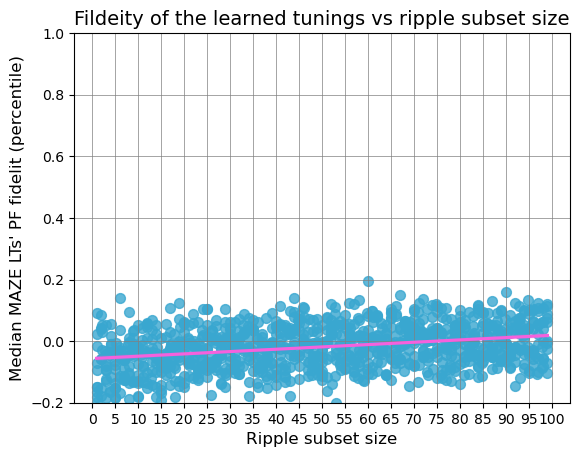

In [139]:
#  calculate percentile score for each iteration
for subset_size in subset_sizes:

    for iter in range(num_iterations):
        median_LT_PF_pearson_corr_diff_sizes[subset_size][iter]["null_percentile"] = np.sum(median_LT_PF_pearson_corr_diff_sizes[subset_size][iter]["data"] > median_LT_PF_pearson_corr_diff_sizes[subset_size][iter]["PF_unit_IDX_shuffle"])/num_PF_shuffles * 100


# Create a list with separate items containing PF fidleities from all iterations corresponding to each ripple subset size

median_LT_PF_corr = {}

# subset_sizes = np.arange(5, 51, 5)

for subset_size in subset_sizes:

    median_LT_PF_corr[subset_size] = []
    for iter in range(num_iterations):
        median_LT_PF_corr[subset_size].append(median_LT_PF_pearson_corr_diff_sizes[subset_size][iter]["null_percentile"])


# concatenate everythng to plot

tot_num_medians = num_iterations * len(subset_sizes)
keys_all = np.full(tot_num_medians, np.nan)
values_all = np.full(tot_num_medians, np.nan)

t = 0
for key, values in median_LT_PF_corr.items():
    keys_all[t:(t+len(values))] = [key]*len(values)
    values_all[t:(t+len(values))] = values

    t = t + len(values)
    
colors = sns.color_palette("husl", 8)


jitter = 0.1

x_jittered = keys_all + np.random.uniform(-jitter, jitter, size = len(keys_all))
y_jittered = values_all + np.random.uniform(-jitter, jitter, size = len(values_all))

sns.regplot(x=x_jittered, y =y_jittered, scatter_kws={"s":50, "color": colors[5]}, fit_reg = True, line_kws = {"color":colors[7], "linestyle": "-"})    

plt.xlabel("Ripple subset size", fontsize = 12)
plt.ylabel("Median POST LTs' PF fidelity", fontsize = 12) # (percentile) 
plt.title("Fildeity of the learned tunings vs ripple subset size", fontsize = 14)
plt.xticks(range(0, 101, 5))

# plt.ylim(-5, 105) 
# plt.yticks(np.arange(0, 101, 20))# 
plt.ylim(-0.2, 1)# 
plt.yticks(np.arange(-0.2, 1.01, 0.2))

plt.grid(True, color = 'gray', linestyle = '-', linewidth=0.5)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)


filename = 'Achilles_10252013.PF_fidelity_vs_ripple_subset_size_POST.svg'
storage_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python'
file_path = os.path.join(storage_dir, filename)

plt.savefig(file_path)

In [71]:
# [v for k, v in learned_tunings_PBE_subsets_diff_sizes.items()][0]
learned_tunings_PBE_subsets_diff_sizes_keys = np.array(list(learned_tunings_PBE_subsets_diff_sizes.keys()))
aa = {k:np.vstack(v) for k, v in learned_tunings_PBE_subsets_diff_sizes.items()}
